## FAES BIOF-509 Final Project
Author: Hale Kpetigo / hale.kpetigo@gmail.com

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import umap ###install with "pip install umap-learn"
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns ### install using pip install seaborn


In [154]:
class BIOF509Unsupervised:
    
    # My Variables
    #pd_data = []
    models = []
    labels = []
    reduced_pd_data = []
    scaled_data = []
    scaler = MinMaxScaler()
    
    # Constructor
    def __init__(self, file):
        # Call Data Loader
        self.load_data(file)

    # Load data set for analysis
    def load_data(self, file):
        self.pd_data = pd.read_csv(file)
    
    def get_data(self):
        return self.pd_data
    
    # Prepare data - Copy expected results and remove column
    def prep_data(self):
        self.labels = self.pd_data['target']
        del self.pd_data["target"]
        
    def print_data(self):
        display(self.pd_data.head())
        display(self.labels)
        
    def plot_data(self):
        sns.pairplot(self.pd_data, vars=self.pd_data.columns[:-1],hue='target')
        
    def plot_clusters(self):
        #model = AgglomerativeClustering(n_clusters=3)
        #self.cluster_labels = model.fit_predict(self.scaled_data)
        sns.scatterplot(x='UMAP Dim. #1', y='UMAP Dim. #2',
            hue='cluster_labels', data=self.reduced_pd_data)
    
    def get_cluster_labels(self):
        model = AgglomerativeClustering(n_clusters=3)
        cluster_labels = model.fit_predict(self.scaled_data)
        return cluster_labels
        
    def scale_data(self):
        # Scale Data
        data_for_scaling = self.pd_data.values
        # scaler = MinMaxScaler()
        self.scaled_data = self.scaler.fit_transform(data_for_scaling)
        
        #print(self.scaled_data[0:5])
        
    def reduce_data(self):       
        # Recude Data
        data_reducer = umap.UMAP()
        
        umap_data = data_reducer.fit_transform(self.scaled_data)

        scaled_umap_data = self.scaler.fit_transform(umap_data)

        self.reduced_pd_data = pd.DataFrame(scaled_umap_data,columns=['UMAP Dim. #1', 'UMAP Dim. #2'])

        self.reduced_pd_data['cluster_labels'] = self.get_cluster_labels()

        #print(self.reduced_pd_data)
    
    def predict(self, eps=[0.1*i for i in range(1,20)], min_samples=list(range(1,11))):
        self.eps = eps
        self.min_samples = min_samples
        for e in eps:
            for ms in min_samples:
                model = DBSCAN(eps=e, min_samples=ms).fit(self.data)
                self.models.append(model)
                self.labels.append(model.fit_predict(self.data))
        return self.models, self.labels
    
    def accuracy(self, target):
        score = []
        for pred in self.labels:
            score.append(self.max_score(pred, target))
        
        max_ind = np.argmax(score)
        best_model = self.models[max_ind]
        print('Max accuracy {} with model {}'.format(score[max_ind], best_model))
        return best_model
    
    def max_score(self, pred, target):
        permutations = [[0, 1], [1, 0]]
        scores = []
        for perm in permutations:
            n_right = 0
            for label, t in zip([0, 1], perm):
                n_right += sum((pred == label)*(target == t)*1)
            scores.append(n_right/len(pred))
        return max(scores)
    
    def BIOF509Kmeans(self):
        self.prep_data()
        self.scale_data()
        self.reduce_data()
        self.plot_clusters()

        
    def BIOF509Density(self):
        dc = DensityClustering(self.scaled_data)
        #print(self.scaled_data, self.models, self.labels)
        dc.predict()
        mytarget = self.labels
        np_lbl = mytarget.array
        best_model = dc.accuracy(np_lbl)
        
    def BIOF509Hierarchical(self):
        display("BIOF509Hierarchical")
        

Max accuracy 0.5478547854785478 with model DBSCAN(eps=1.1, min_samples=1)


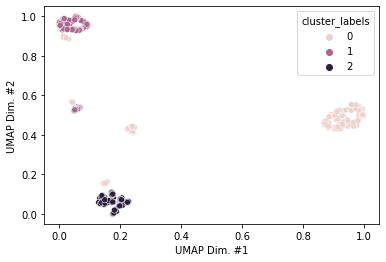

In [155]:
FinalProject = BIOF509Unsupervised("heart 2.csv")
# FinalProject.plot_data()

FinalProject.BIOF509Kmeans()
FinalProject.BIOF509Density()
#FinalProject.BIOF509Hierarchical()




In [140]:
from sklearn.cluster import DBSCAN

class DensityClustering:
    def __init__(self, data):
        # assumes data is a df, also no columns to drop
        self.data = data
        self.models = []
        self.labels = []
        
    def predict(self, eps=[0.1*i for i in range(1,20)], min_samples=list(range(1,11))):
        self.eps = eps
        self.min_samples = min_samples
        for e in eps:
            for ms in min_samples:
                model = DBSCAN(eps=e, min_samples=ms).fit(self.data)
                self.models.append(model)
                self.labels.append(model.fit_predict(self.data))
        return self.models, self.labels
    
    def accuracy(self, target):
        score = []
        for pred in self.labels:
            score.append(self.max_score(pred, target))
        
        max_ind = np.argmax(score)
        best_model = self.models[max_ind]
        print('Max accuracy {} with model {}'.format(score[max_ind], best_model))
        return best_model
    
    def max_score(self, pred, target):
        permutations = [[0, 1], [1, 0]]
        scores = []
        for perm in permutations:
            n_right = 0
            for label, t in zip([0, 1], perm):
                n_right += sum((pred == label)*(target == t)*1)
            scores.append(n_right/len(pred))
        return max(scores)
              

In [141]:
dc = DensityClustering(FinalProject.scaled_data)
print(dc.data, dc.models, dc.labels)
#dc.predict()
#best_model = dc.accuracy(FinalProject.pd_data)

[[0.70833333 1.         1.         ... 0.         0.         0.33333333]
 [0.16666667 1.         0.66666667 ... 0.         0.         0.66666667]
 [0.25       0.         0.33333333 ... 1.         0.         0.66666667]
 ...
 [0.8125     1.         0.         ... 0.5        0.5        1.        ]
 [0.58333333 1.         0.         ... 0.5        0.25       1.        ]
 [0.58333333 0.         0.33333333 ... 0.5        0.25       0.66666667]] [] []


In [142]:
dc.predict()
mytarget = FinalProject.labels
np_lbl = mytarget.array
best_model = dc.accuracy(np_lbl)

Max accuracy 0.5478547854785478 with model DBSCAN(eps=1.1, min_samples=1)


In [143]:
# Try with only 2 features, based on our pairwise plot above
dc_reduced = DensityClustering(FinalProject.scaled_data[:, 1:3])
dc_reduced.predict()
best_model_reduced = dc_reduced.accuracy(np_lbl)

Max accuracy 0.6138613861386139 with model DBSCAN(eps=0.4, min_samples=1)


In [107]:
class BIOF509Supervised:
    
    """My Variables"""
    pd_data = []
    labels = []
    scaled_data = []
    reduced_pd_data = []

    def BIOF509SVM(self):
        svm_model = SVC(kernel='linear')
        skf = StratifiedKFold(n_splits=5,shuffle=True)
        all_feature_importances = np.zeros((len(set(labels)),len(self.pd_data.columns)))
        all_labels = []
        all_predictions = []

        accuracy = 0

        for train_index, test_index in skf.split(self.pd_data.values, self.labels):

                ''' training dataset '''
                X_train, y_train = self.pd_data.values[train_index], self.labels[train_index]


                ''' testing dataset '''
                X_test, y_test = self.pd_data.values[test_index], self.labels[test_index]


                ''' fit the model to the data - this is where the algorithm learns the patterns and finds
                the hyperplane'''
                svm_model.fit(X_train,y_train)


                ''' 
                The coef values tell us which features were most important in finding the SVM hyperplanes
                We can only do this for a linear SVM, which does not add on extra dimensions. 

                In many cases, decision tree methods work better for interpretation
                '''
                all_feature_importances += svm_model.coef_


                ''' now, we will predict the labels'''
                predictions = svm_model.predict(X_test)


                ''' 
                Use the extend function to add the new predictions onto the list of predictions
                list = [1,2]
                list.extend([3,4])
                list = [1,2,3,4]
                '''
                all_predictions.extend(predictions)

                ''' Use extend function to add the new labels onto the list of labels'''
                all_labels.extend(y_test)

                ''' add the new accuracy score to the other scores - we will average them at the end'''
                accuracy += accuracy_score(predictions,y_test)

        print("PREDICTION ACCURACY")
        print(accuracy/5)
        print()
        print('ALL LABELS')
        print(all_labels)
        print()
        print('ALL PREDICTIONS')
        print(all_predictions)
        
    def BIOFDecisionTree(self):
        display("BIOFDecisionTree")
        
    def BIOFBayesian(self):
        display("BIOFBayesian")

In [102]:
pd_data = pd.read_csv("heart 2.csv")
display(pd_data.head())

labels = pd_data['target']
display(labels)

del pd_data["target"]
display(pd_data.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


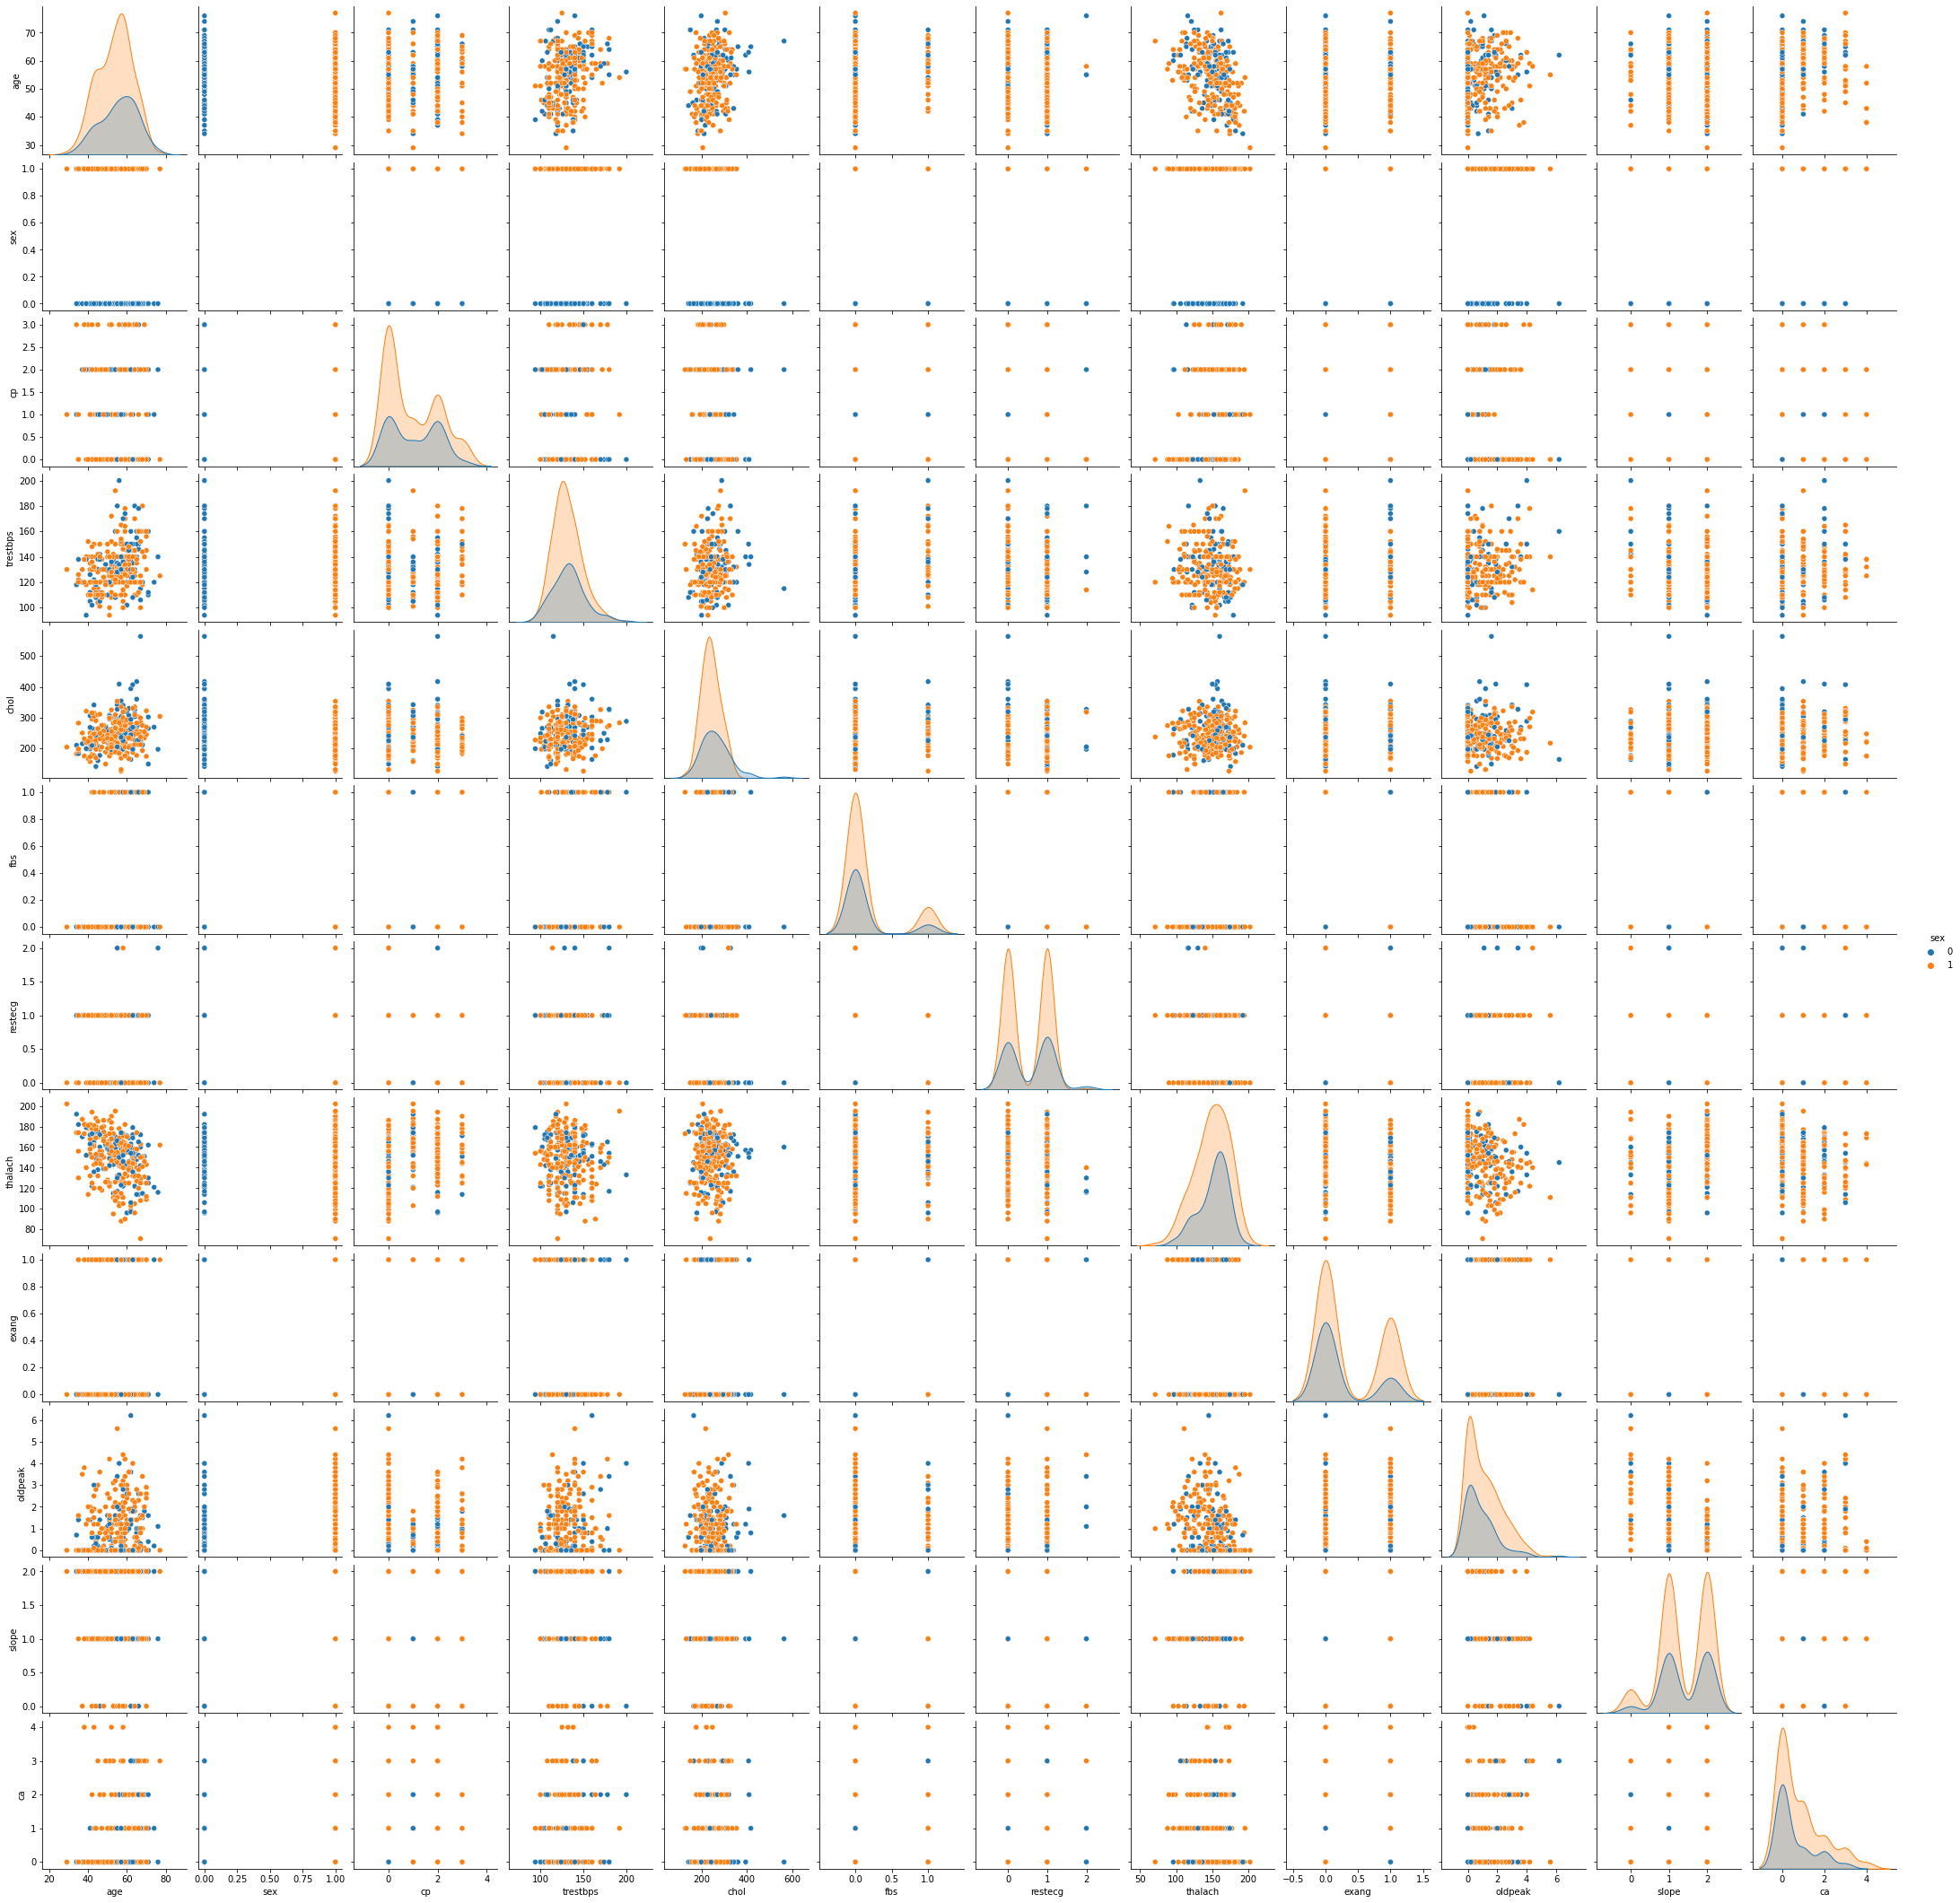

In [103]:
sns.pairplot(pd_data, vars=pd_data.columns[:-1],hue='sex')

In [104]:
data_for_scaling = pd_data.values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_for_scaling)
print(scaled_data[0:5])

[[0.70833333 1.         1.         0.48113208 0.24429224 1.
  0.         0.60305344 0.         0.37096774 0.         0.
  0.33333333]
 [0.16666667 1.         0.66666667 0.33962264 0.28310502 0.
  0.5        0.88549618 0.         0.56451613 0.         0.
  0.66666667]
 [0.25       0.         0.33333333 0.33962264 0.17808219 0.
  0.         0.77099237 0.         0.22580645 1.         0.
  0.66666667]
 [0.5625     1.         0.33333333 0.24528302 0.25114155 0.
  0.5        0.81679389 0.         0.12903226 1.         0.
  0.66666667]
 [0.58333333 0.         0.         0.24528302 0.52054795 0.
  0.5        0.70229008 1.         0.09677419 1.         0.
  0.66666667]]


In [105]:
model = AgglomerativeClustering(n_clusters=3)
cluster_labels = model.fit_predict(scaled_data)

In [106]:
data_reducer = umap.UMAP()
umap_data = data_reducer.fit_transform(scaled_data)


scaled_umap_data = scaler.fit_transform(umap_data)


''' add back to a dataframe because it's easier to keep track of things
(all indices and columns have names that we can reference)'''

reduced_pd_data = pd.DataFrame(scaled_umap_data,columns=['UMAP Dim. #1', 'UMAP Dim. #2'])

''' add in our clustering labels from hierarchical clustering '''
reduced_pd_data['cluster_labels'] = cluster_labels

''' check out the reduced data here!'''
print(reduced_pd_data)

     UMAP Dim. #1  UMAP Dim. #2  cluster_labels
0        0.273786      0.415674               0
1        0.952716      0.537738               0
2        0.304006      0.107129               2
3        0.940289      0.428475               0
4        0.003789      0.174781               1
..            ...           ...             ...
298      0.018017      0.186142               1
299      0.934087      0.534424               0
300      0.295597      0.395908               0
301      0.305571      0.987472               1
302      0.281361      0.075459               2

[303 rows x 3 columns]


<AxesSubplot:xlabel='UMAP Dim. #1', ylabel='UMAP Dim. #2'>

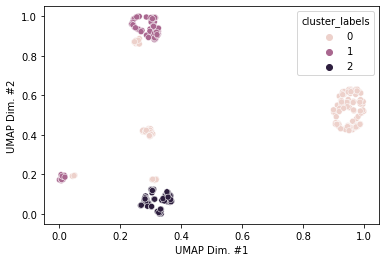

In [107]:
sns.scatterplot(x='UMAP Dim. #1', y='UMAP Dim. #2',
            hue='cluster_labels', data=reduced_pd_data)

In [108]:
svm_model = SVC(kernel='linear')
skf = StratifiedKFold(n_splits=5,shuffle=True)
all_feature_importances = np.zeros((len(set(labels)),len(pd_data.columns)))
all_labels = []
all_predictions = []

accuracy = 0

for train_index, test_index in skf.split(pd_data.values, labels):
    
        ''' training dataset '''
        X_train, y_train = pd_data.values[train_index], labels[train_index]

        
        ''' testing dataset '''
        X_test, y_test = pd_data.values[test_index], labels[test_index]

        
        ''' fit the model to the data - this is where the algorithm learns the patterns and finds
        the hyperplane'''
        svm_model.fit(X_train,y_train)
        
        
        ''' 
        The coef values tell us which features were most important in finding the SVM hyperplanes
        We can only do this for a linear SVM, which does not add on extra dimensions. 
        
        In many cases, decision tree methods work better for interpretation
        '''
        all_feature_importances += svm_model.coef_
        
        
        ''' now, we will predict the labels'''
        predictions = svm_model.predict(X_test)
        
        
        ''' 
        Use the extend function to add the new predictions onto the list of predictions
        list = [1,2]
        list.extend([3,4])
        list = [1,2,3,4]
        '''
        all_predictions.extend(predictions)
        
        ''' Use extend function to add the new labels onto the list of labels'''
        all_labels.extend(y_test)
        
        ''' add the new accuracy score to the other scores - we will average them at the end'''
        accuracy += accuracy_score(predictions,y_test)

print("PREDICTION ACCURACY")
print(accuracy/5)
print()
print('ALL LABELS')
print(all_labels)
print()
print('ALL PREDICTIONS')
print(all_predictions)



PREDICTION ACCURACY
0.8415300546448087

ALL LABELS
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

ALL PREDICTIONS
[1, 1, 1, 1, 1, 1, 1, 

<AxesSubplot:>

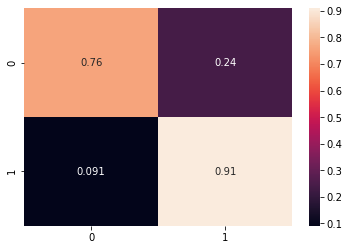

In [109]:

''' here, I input the labels and predictions into the Scikit learn confusion_matrix function and they
will generate a confusion matrix for me'''
cm = confusion_matrix(all_labels,all_predictions,normalize= 'true')

''' turn it into a dataframe so seaborn will label the graph using the columns/indicies of the df'''
df_cm = pd.DataFrame(cm,index=[0,1],columns=[0,1])

''' graph using seaborn heatmap function - annot=True so labels will appear'''
sns.heatmap(df_cm, annot=True)

[0.02171370238494319, 3.402940260682456, 2.1643083560420844, 0.052102349784111844, 0.007372181347742905, 0.29398570113652234, 0.7568183673186087, 0.05212715204675078, 2.0611268953962116, 1.3778930699221004, 1.1890153854153844, 1.7619312512993208, 2.7617493124061476]


Text(0.5, 1.0, 'Feature Importances')

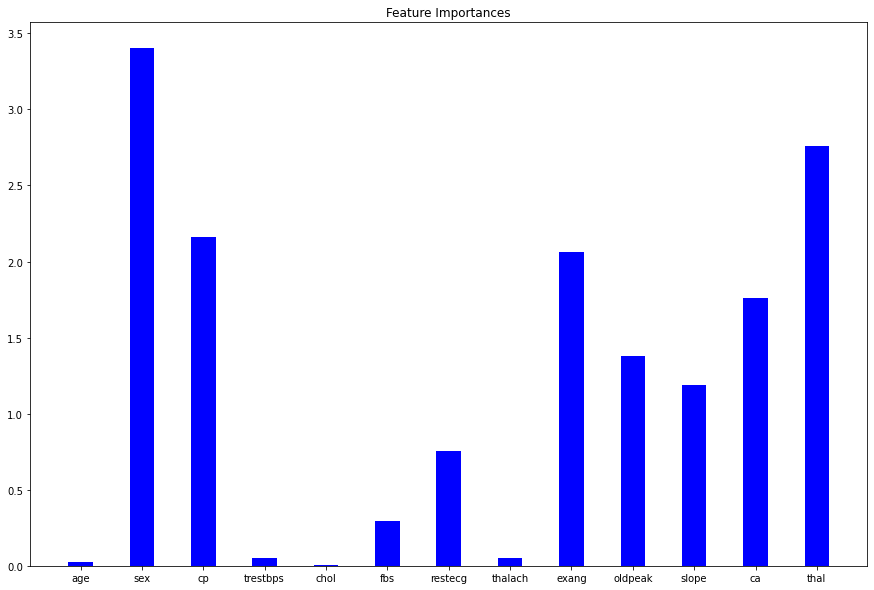

In [110]:
average_feature_importances = []

for i in range(all_feature_importances.shape[1]):
    average_value = 0
    for array in all_feature_importances:
        average_value += abs(array[i])
    average_feature_importances.append(average_value/3) 
    '''3 instead of 5'''
        
print(average_feature_importances)    

''' make the figure a little bigger than default'''
plt.figure(figsize = (15,10))

''' use matplotlib's bar graph function to graph feature importances
X axis = feature name
y axis = feature importance values
'''
plt.bar(list(pd_data.columns),average_feature_importances, color ='blue',  width = 0.4) 
plt.title('Feature Importances')

In [111]:
pd_data_pred = pd.read_csv("heart.csv")
display(pd_data_pred.head())


del pd_data_pred["target"]
display(pd_data_pred.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2


In [117]:
svm_model = SVC(kernel='linear')
skf = StratifiedKFold(n_splits=5,shuffle=True)
all_feature_importances = np.zeros((len(set(labels)),len(pd_data.columns)))
all_labels = []
all_predictions = []

accuracy = 0

''' training dataset '''
X_train, y_train = pd_data.values, labels


''' testing dataset '''
X_test, y_test = pd_data_pred.values, labels


''' fit the model to the data - this is where the algorithm learns the patterns and finds
the hyperplane'''
svm_model.fit(X_train,y_train)


''' 
The coef values tell us which features were most important in finding the SVM hyperplanes
We can only do this for a linear SVM, which does not add on extra dimensions. 

In many cases, decision tree methods work better for interpretation
'''
all_feature_importances += svm_model.coef_


''' now, we will predict the labels'''
predictions = svm_model.predict(X_test)


''' 
Use the extend function to add the new predictions onto the list of predictions
list = [1,2]
list.extend([3,4])
list = [1,2,3,4]
'''
'''all_predictions.extend(predictions)'''

''' Use extend function to add the new labels onto the list of labels'''
'''all_labels.extend(y_test)'''

''' add the new accuracy score to the other scores - we will average them at the end'''
accuracy += accuracy_score(predictions,y_test)

ValueError: Found input variables with inconsistent numbers of samples: [1025, 303]

In [118]:
print("PREDICTION ACCURACY")
print(accuracy/5)
print()
print('ALL LABELS')
print(all_labels)
print()
print('ALL PREDICTIONS')
print(all_predictions)



PREDICTION ACCURACY
0.0

ALL LABELS
[]

ALL PREDICTIONS
[]
